In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

# Mostrar floats com duas casas decimas
pd.set_option('display.float_format',  lambda x: '%.4g' % x)
pd.options.display.max_colwidth = 20
pd.options.display.max_columns = 20
pd.options.display.max_rows = 4

In [4]:
# Load magic stocks prices
df_mag = pd.read_csv(
    "../data/3_prices.csv", parse_dates=['datneg', 'cutoff_date', 'next_cutoff'])
df_mag

,datneg,codneg,nomres,preult,premed,cutoff_date,next_cutoff
0,2014-04-10,ABEV3,AMBEV S/A,13.16,13.1,2014-04-10,2015-04-10
1,2014-04-11,ABEV3,AMBEV S/A,13.49,13.34,2014-04-10,2015-04-10
...,...,...,...,...,...,...,...
81570,2021-04-09,YDUQ3,YDUQS PART,30.57,30.53,2020-04-09,2021-04-12
81571,2021-04-12,YDUQ3,YDUQS PART,30.58,30.59,2020-04-09,2021-04-12


In [5]:
# Create a column with the first price of the stock for each interval
df_mag['first_value'] = df_mag.groupby(by=['codneg', 'cutoff_date'])['premed'].transform('first')
df_mag

,datneg,codneg,nomres,preult,premed,cutoff_date,next_cutoff,first_value
0,2014-04-10,ABEV3,AMBEV S/A,13.16,13.1,2014-04-10,2015-04-10,13.1
1,2014-04-11,ABEV3,AMBEV S/A,13.49,13.34,2014-04-10,2015-04-10,13.1
...,...,...,...,...,...,...,...,...
81570,2021-04-09,YDUQ3,YDUQS PART,30.57,30.53,2020-04-09,2021-04-12,26.16
81571,2021-04-12,YDUQ3,YDUQS PART,30.58,30.59,2020-04-09,2021-04-12,26.16


In [6]:
# Normalize the series with the first price of the stock for the period
df_mag['price_n'] = 100 * df_mag.premed / df_mag.first_value 
df_mag

,datneg,codneg,nomres,preult,premed,cutoff_date,next_cutoff,first_value,price_n
0,2014-04-10,ABEV3,AMBEV S/A,13.16,13.1,2014-04-10,2015-04-10,13.1,100
1,2014-04-11,ABEV3,AMBEV S/A,13.49,13.34,2014-04-10,2015-04-10,13.1,101.8
...,...,...,...,...,...,...,...,...,...
81570,2021-04-09,YDUQ3,YDUQS PART,30.57,30.53,2020-04-09,2021-04-12,26.16,116.7
81571,2021-04-12,YDUQ3,YDUQS PART,30.58,30.59,2020-04-09,2021-04-12,26.16,116.9


In [7]:
# Create a new dataframe with stocks daily mean price for each cutoff group
df_ret = df_mag.groupby(by=['datneg', 'next_cutoff'])['price_n'].mean().reset_index()
df_ret.rename(columns={'price_n': 'daily_mean_price'}, inplace=True)
df_ret

,datneg,next_cutoff,daily_mean_price
0,2011-04-11,2012-04-09,100
1,2011-04-12,2012-04-09,99.18
...,...,...,...
2773,2022-06-08,2023-04-11,99.42
2774,2022-06-09,2023-04-11,99.19


In [8]:
# Create a column for storing the last daily mean price (dmp) of each period
df_ret['group_last_dmp'] = df_ret.groupby(by=['next_cutoff'])['daily_mean_price'].transform('last')
df_ret

,datneg,next_cutoff,daily_mean_price,group_last_dmp
0,2011-04-11,2012-04-09,100,114.5
1,2011-04-12,2012-04-09,99.18,114.5
...,...,...,...,...
2773,2022-06-08,2023-04-11,99.42,99.19
2774,2022-06-09,2023-04-11,99.19,99.19


In [9]:
df_ret['accum_adjustment'] = np.where(
    df_ret.datneg == df_ret.next_cutoff,
    df_ret.group_last_dmp / 100,
    1
)
df_ret

,datneg,next_cutoff,daily_mean_price,group_last_dmp,accum_adjustment
0,2011-04-11,2012-04-09,100,114.5,1
1,2011-04-12,2012-04-09,99.18,114.5,1
...,...,...,...,...,...
2773,2022-06-08,2023-04-11,99.42,99.19,1
2774,2022-06-09,2023-04-11,99.19,99.19,1


In [10]:
df_ret['accum_adjustment'] = df_ret['accum_adjustment'].cumprod() 
df_ret['total_return'] = df_ret['accum_adjustment'] * df_ret['daily_mean_price']
df_ret

,datneg,next_cutoff,daily_mean_price,group_last_dmp,accum_adjustment,total_return
0,2011-04-11,2012-04-09,100,114.5,1,100
1,2011-04-12,2012-04-09,99.18,114.5,1,99.18
...,...,...,...,...,...,...
2773,2022-06-08,2023-04-11,99.42,99.19,2.918,290.1
2774,2022-06-09,2023-04-11,99.19,99.19,2.918,289.4


In [11]:
df_ret.query('datneg == next_cutoff')

,datneg,next_cutoff,daily_mean_price,group_last_dmp,accum_adjustment,total_return
248,2012-04-09,2012-04-09,114.5,114.5,1.145,131.2
495,2013-04-10,2013-04-10,119.2,119.2,1.365,162.7
...,...,...,...,...,...,...
2482,2021-04-12,2021-04-12,177.8,177.8,2.932,521.3
2732,2022-04-11,2022-04-11,99.53,99.53,2.918,290.5


In [12]:
df_ret.drop_duplicates('datneg', keep='last', inplace=True)
df_ret

,datneg,next_cutoff,daily_mean_price,group_last_dmp,accum_adjustment,total_return
0,2011-04-11,2012-04-09,100,114.5,1,100
1,2011-04-12,2012-04-09,99.18,114.5,1,99.18
...,...,...,...,...,...,...
2773,2022-06-08,2023-04-11,99.42,99.19,2.918,290.1
2774,2022-06-09,2023-04-11,99.19,99.19,2.918,289.4


In [14]:
# Load IBOV series
# s3://aq-dl/HistoricalQuotations/base_adj.feather
file_path = "/mnt/aq_disk/data/HistoricalQuotations/processed/base_adj.feather"
df_ibov = (pd
    .read_feather(file_path)
    .query('codneg == "IBOV" and datneg >= "2011-04-11"')
    [['datneg', 'premed']]
)
df_ibov.reset_index(drop=True, inplace=True)
df_ibov

,datneg,premed
0,2011-04-11,6.852e+04
1,2011-04-12,6.748e+04
...,...,...
2761,2022-06-09,1.078e+05
2762,2022-06-10,1.062e+05


In [15]:
df_ibov.premed = 100 * df_ibov.premed / df_ibov.loc[0, 'premed']
df_ibov

,datneg,premed
0,2011-04-11,100
1,2011-04-12,98.48
...,...,...
2761,2022-06-09,157.3
2762,2022-06-10,154.9


In [16]:
df_ret = df_ret.merge(right=df_ibov, how='inner')
df_ret.rename(
    columns={"price_acum": "MagicFormula", "premed": "Ibovespa"}, inplace=True)
df_ret.set_index('datneg', inplace=True)
df_ret

,next_cutoff,daily_mean_price,group_last_dmp,accum_adjustment,total_return,Ibovespa
datneg,,,,,,
2011-04-11,2012-04-09,100,114.5,1,100,100
2011-04-12,2012-04-09,99.18,114.5,1,99.18,98.48
...,...,...,...,...,...,...
2022-06-08,2023-04-11,99.42,99.19,2.918,290.1,159.3
2022-06-09,2023-04-11,99.19,99.19,2.918,289.4,157.3


<AxesSubplot:xlabel='datneg'>

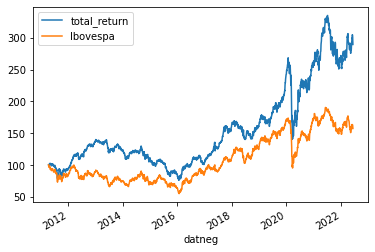

In [17]:
df_ret[['total_return', 'Ibovespa']].plot()

<AxesSubplot:xlabel='datneg'>

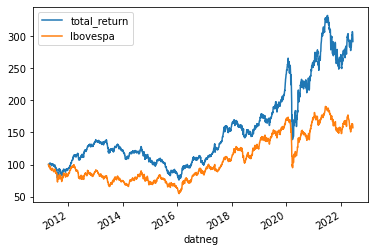

In [25]:
df_ret[['total_return', 'Ibovespa']].plot()

In [75]:
df_ret.query('"2019-11-01" < datneg < "2019-12-24"')

,next_cutoff,price_n,last_group_price,MagicFormula,BOVA11
datneg,,,,,
2019-11-04,2020-04-09,106,85.4,135,154
2019-11-05,2020-04-09,106,85.4,136,154
2019-11-06,2020-04-09,106,85.4,135,154
...,...,...,...,...,...
2019-12-19,2020-04-09,119,85.4,152,163
2019-12-20,2020-04-09,120,85.4,153,163
2019-12-23,2020-04-09,122,85.4,155,164
